In [1]:
from fastbook import *

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [3]:
df = pd.read_csv(path/'train.csv')
df.head(), path.ls()

(        fname        labels  is_valid
 0  000005.jpg         chair      True
 1  000007.jpg           car      True
 2  000009.jpg  horse person      True
 3  000012.jpg           car     False
 4  000016.jpg       bicycle      True,
 (#8) [Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/valid.json')])

In [6]:
dblock = DataBlock()

In [7]:
dset = dblock.datasets(df)

In [12]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')


dblock = DataBlock(
    blocks=(ImageBlock,MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
)

dset = dblock.datasets(df)
dset.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [15]:
idxs = torch.where(dset.train[0][1]==1.)[0]

In [21]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid
    

In [33]:
dblock = DataBlock(
    blocks=(ImageBlock,MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=splitter,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)
dset = dblock.datasets(df)
dls = dblock.dataloaders(df)

## Binary cross entropy

In [34]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [35]:
x,y = to_cpu(dls.train.one_batch())
actives = learn.model(x)
actives.shape

torch.Size([64, 20])

In [37]:
x.shape, y.shape

((64, 3, 128, 128), (64, 20))

In [41]:
def binary_cross_entropy(inputs,targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [39]:
loss_func = nn.BCEWithLogitsLoss()
loss_func(actives,y)

TensorMultiCategory(1.1144, grad_fn=<AliasBackward>)

In [42]:
binary_cross_entropy(actives,y)

TensorMultiCategory(1.1144, grad_fn=<AliasBackward>)

In [43]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.944133,0.702065,0.238805,00:30
1,0.828701,0.566588,0.284721,00:30
2,0.609500,0.204989,0.811096,00:30
3,0.361553,0.125812,0.942390,00:30


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132185,0.114655,0.942849,00:37
1,0.115005,0.107964,0.951255,00:37
2,0.096657,0.104320,0.953048,00:37


In [45]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10431979596614838,0.9334858655929565]

In [47]:
learn.metrics = partial(accuracy_multi, thresh=0.95)
learn.validate()

(#2) [0.10431979596614838,0.9523308277130127]

In [48]:
learn.metrics = partial(accuracy_multi, thresh=0.5)
learn.validate()

(#2) [0.10431979596614838,0.9631472229957581]

In [49]:
preds,targs = learn.get_preds()
preds.shape, targs.shape

(torch.Size([2510, 20]), (2510, 20))

In [50]:
preds[0], targs[0]

(tensor([0.0015, 0.0071, 0.0020, 0.0021, 0.1541, 0.0033, 0.0062, 0.0115, 0.9338, 0.0010, 0.3236, 0.0064, 0.0020, 0.0021, 0.2222, 0.1375, 0.0041, 0.3974, 0.0013, 0.3851]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

## regression

In [53]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [55]:
img_files = get_image_files(path)
def get_pose_file(x):
    return Path('{}pose.txt'.format(str(x)[:-7]))

get_pose_file(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/19/frame_00433_pose.txt')

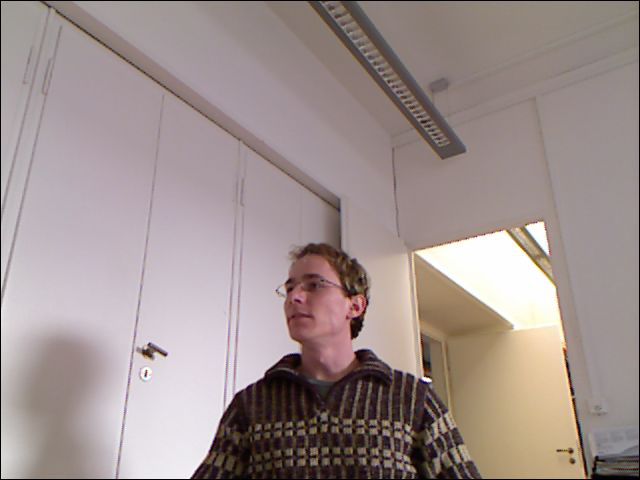

In [56]:
img1 = PILImage.create(img_files[0])
img1

In [61]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(get_pose_file(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [63]:
biwi_dblock = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name == '13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                   Normalize.from_stats(*imagenet_stats)
               ]
)

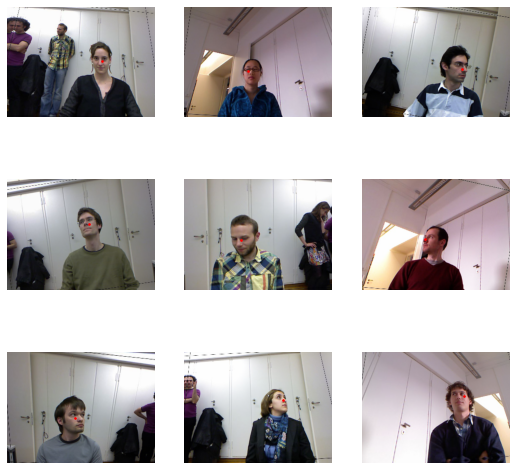

In [67]:
dls = biwi_dblock.dataloaders(path)
dls.show_batch(nrows=3, ncols=3)

In [76]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [71]:
def sigmoid_range(x, lo,hi):
    return torch.sigmoid(x)*(hi - lo) + lo

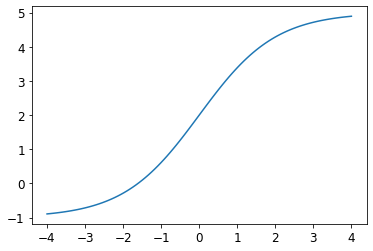

In [74]:
plot_function(
    partial(sigmoid_range,lo= -1, hi=5),
    min=-4, max=4
)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=6.30957365501672e-05)

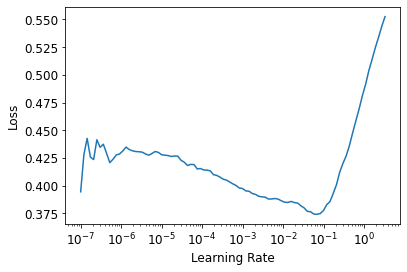

In [77]:
learn.lr_find()

In [79]:
learn.fine_tune(3, 5e-2)

epoch,train_loss,valid_loss,time
0,0.029902,0.013103,03:53


epoch,train_loss,valid_loss,time
0,0.003881,0.001521,05:22
1,0.002281,0.000515,05:21
2,0.001359,0.000155,05:21


In [82]:
learn.arch()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
x,y = dls.one_batch()

In [86]:
x.shape

(64, 3, 240, 320)

In [88]:
x1 = x[0]
y1 = y[0]

In [110]:
learn.model(x1.unsqueeze(0))

tensor([[0.0674, 0.0056]], device='cuda:0', grad_fn=<AddBackward0>)

In [111]:
y1

TensorPoint([[0.0636, 0.0120]], device='cuda:0')